# Explore here

In [1]:
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.model_selection import KFold
import joblib

In [3]:
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
df = pd.read_csv(url)

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


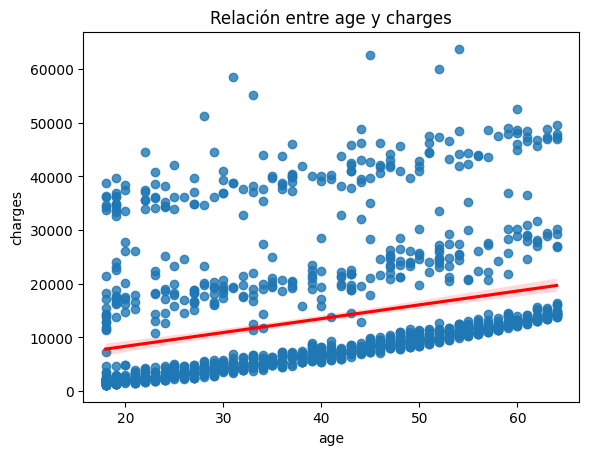

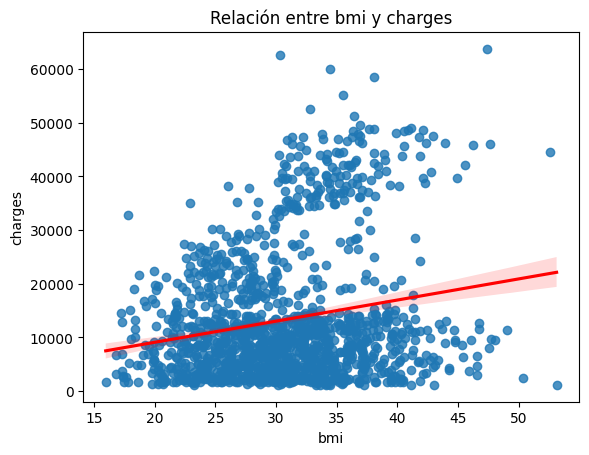

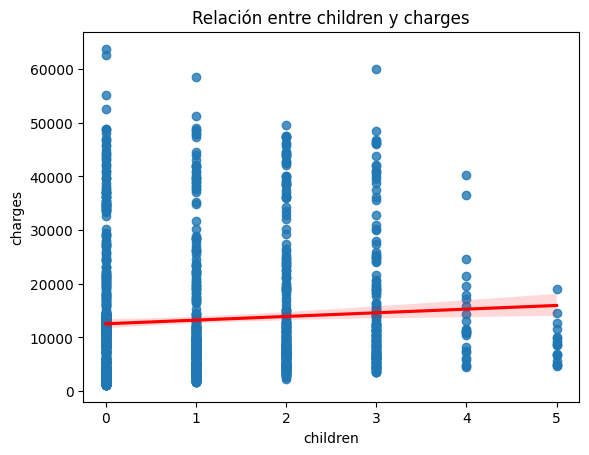

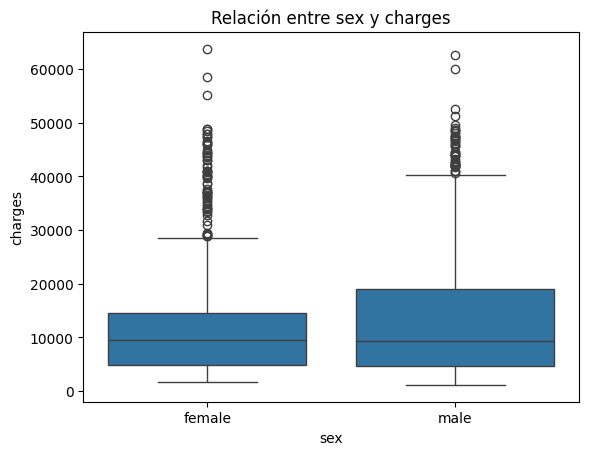

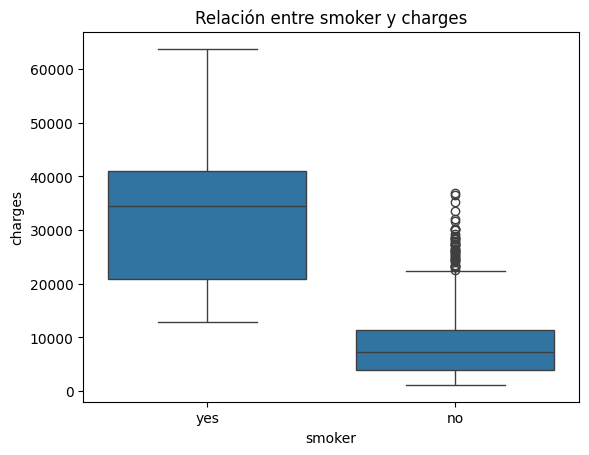

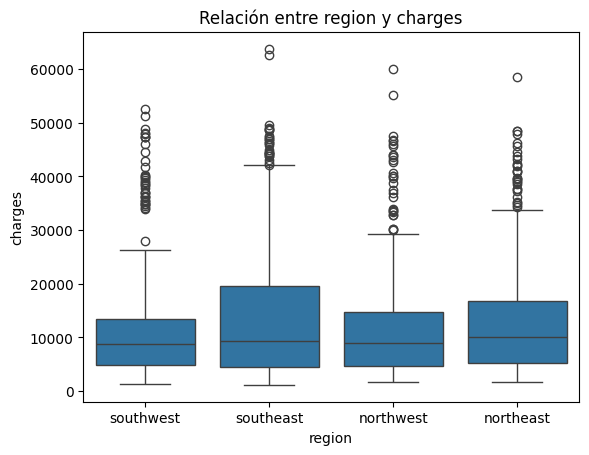

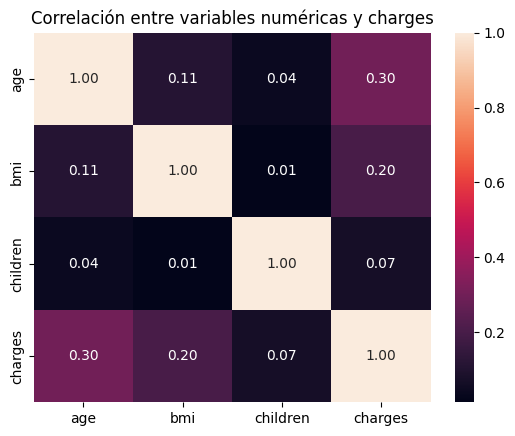

In [5]:
# Variables numéricas: 'age', 'bmi', 'children'
numerical_vars = ['age', 'bmi', 'children']

# Gráficos de dispersión para variables numéricas
for var in numerical_vars:
    sns.regplot(data=df, x=var, y='charges', line_kws={"color": "red"})
    plt.title(f'Relación entre {var} y charges')
    plt.show()

# Boxplots para variables categóricas: 'sex', 'smoker', 'region'
categorical_vars = ['sex', 'smoker', 'region']
for var in categorical_vars:
    sns.boxplot(data=df, x=var, y='charges')
    plt.title(f'Relación entre {var} y charges')
    plt.show()

# Mapa de calor de correlación para variables numéricas
sns.heatmap(df[numerical_vars + ['charges']].corr(), annot=True, fmt=".2f", cbar=True)
plt.title('Correlación entre variables numéricas y charges')
plt.show()

In [6]:
X = df.drop(['charges'], axis=1)
y = df.charges
X, y

(      age     sex     bmi  children smoker     region
 0      19  female  27.900         0    yes  southwest
 1      18    male  33.770         1     no  southeast
 2      28    male  33.000         3     no  southeast
 3      33    male  22.705         0     no  northwest
 4      32    male  28.880         0     no  northwest
 ...   ...     ...     ...       ...    ...        ...
 1333   50    male  30.970         3     no  northwest
 1334   18  female  31.920         0     no  northeast
 1335   18  female  36.850         0     no  southeast
 1336   21  female  25.800         0     no  southwest
 1337   61  female  29.070         0    yes  northwest
 
 [1338 rows x 6 columns],
 0       16884.92400
 1        1725.55230
 2        4449.46200
 3       21984.47061
 4        3866.85520
            ...     
 1333    10600.54830
 1334     2205.98080
 1335     1629.83350
 1336     2007.94500
 1337    29141.36030
 Name: charges, Length: 1338, dtype: float64)

In [7]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
def preprocess_features(df, scaler=None):
    # One-Hot Encoding para variables categóricas
    df_processed = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)
    
    # Convertir variables booleanas a enteros
    for col in df_processed:
        if df_processed[col].dtype == 'bool':
            df_processed[col] = df_processed[col].astype(int)
    
    # Escalar variables numéricas si scaler es proporcionado, de lo contrario, ajustar y transformar
    numerical_vars = ['age', 'bmi', 'children']
    if scaler is not None:
        df_processed[numerical_vars] = scaler.transform(df_processed[numerical_vars])
    else:
        scaler = StandardScaler()
        df_processed[numerical_vars] = scaler.fit_transform(df_processed[numerical_vars])
    
    
    return df_processed, scaler

X_train_processed, scaler = preprocess_features(X_train)
X_test_processed, _ = preprocess_features(X_test, scaler)



In [9]:
X

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


In [10]:
# Crear el modelo de regresión lineal
X = sm.add_constant(X_train_processed)
model = sm.OLS(y_train, X_train_processed)

# Ajustar el modelo a los datos
results = model.fit()

In [11]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.838
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              687.1
Date:                Fri, 15 Mar 2024   Prob (F-statistic):                        0.00
Time:                        19:13:50   Log-Likelihood:                         -11026.
No. Observations:                1070   AIC:                                  2.207e+04
Df Residuals:                    1062   BIC:                                  2.211e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### Vamos a estudiar cómo influyen las distintas variables en la multicolinealidad detectada.

In [12]:
# Añadir constante al conjunto de características para el análisis VIF
X_const = add_constant(X_train_processed)

# Calcular VIF para cada variable
vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

           Variable       VIF
0             const  5.369250
1               age  1.023084
2               bmi  1.094986
3          children  1.005643
4          sex_male  1.006303
5        smoker_yes  1.011703
6  region_northwest  1.493159
7  region_southeast  1.613285
8  region_southwest  1.515246


### Estos resultados indican dan un VIF adecuado (salvo quizás para el valor de la constante, que se encuentra en el rango 5-10, el cual ya no es tan deseable. Que el resto de variables tengan un valor cercano a 1 indica la casi ausencia de multicolinealidad entre ellas)

In [13]:
# Crear el modelo de regresión lineal
X_adjusted = sm.add_constant(X_train_processed)
model = sm.OLS(y_train, X_adjusted)

# Ajustar el modelo a los datos
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     380.9
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          1.32e-305
Time:                        19:13:50   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1061   BIC:                         2.175e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8955.2448    434.334  

### Vamos a prescindir de las variables con un p-valor alto. Children es un caso extremo, podemos incluirlo o descartarlo. Vamos a estudiar el modelo con ambos planteamientos

In [14]:
# Excluyendo variables no significativas
variables_to_keep = ['age', 'bmi', 'children', 'smoker_yes']
X_simplified = X_adjusted[variables_to_keep]

# Añadir una constante a las variables que quedan
X_simplified_const = sm.add_constant(X_simplified)

# Ajustar el modelo OLS con las variables reducidas
model_simplified = sm.OLS(y_train, X_simplified_const).fit()

# Imprimir el resumen del modelo simplificado
print(model_simplified.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     762.1
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          1.26e-310
Time:                        19:13:50   Log-Likelihood:                -10847.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1065   BIC:                         2.173e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8482.8126    210.233     40.350      0.0

In [15]:
# Convertir X y y a matrices de numpy para su uso en scikit-learn
X_np = X_adjusted.to_numpy()
y_np = y_train.to_numpy()

# Inicializar el modelo de regresión lineal
model = LinearRegression()

# Crear un scorer de R-squared para la validación cruzada
r2_scorer = make_scorer(score_func=r2_score)

# Configurar la validación cruzada K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Realizar la validación cruzada
r2_scores = cross_val_score(model, X_np, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de los puntajes de R-squared
r2_average = r2_scores.mean()
r2_std = r2_scores.std()

print(f'R-squared promedio en la validación cruzada: {r2_average:.3f}')
print(f'Desviación estándar de R-squared en la validación cruzada: {r2_std:.3f}')

R-squared promedio en la validación cruzada: 0.732
Desviación estándar de R-squared en la validación cruzada: 0.044


In [16]:
# Vuelve al punto después del escalado y antes de excluir variables
X_without_children = X_train_processed.drop(['children'], axis=1)

# Para mantener coherencia con el análisis previo, conservamos solo las variables de interés (ya sin 'children')
variables_to_keep = ['age', 'bmi', 'smoker_yes', 'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']
X_without_children_simplified = X_without_children[variables_to_keep]

# Añadir constante para el modelo sin 'children'
X_without_children_simplified_const = sm.add_constant(X_without_children_simplified)

# Ajustar el modelo OLS sin 'children'
model_without_children = sm.OLS(y_train, X_without_children_simplified_const).fit()

# Imprimir el resumen del modelo simplificado sin 'children'
print("\nModelo EXCLUYENDO 'children':")
print(model_without_children.summary())

# Convertir X y y a matrices de numpy para su uso en scikit-learn
# Utilizamos X_without_children_simplified_const para mantener coherencia
X_np_without_children = X_without_children_simplified_const.to_numpy()

# Realizar la validación cruzada con el conjunto sin 'children'
r2_scores_without_children = cross_val_score(model, X_np_without_children, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de los puntajes de R-squared sin 'children'
r2_average_without_children = r2_scores_without_children.mean()
r2_std_without_children = r2_scores_without_children.std()

print(f"R-squared promedio en la validación cruzada SIN 'children': {r2_average_without_children:.3f}")
print(f"Desviación estándar de R-squared en la validación cruzada SIN 'children': {r2_std_without_children:.3f}")



Modelo EXCLUYENDO 'children':
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     431.5
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          2.64e-305
Time:                        19:13:50   Log-Likelihood:                -10849.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1062   BIC:                         2.175e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const    

### Vamos a simplificar el modelo quitando las variables no significativas

In [18]:
#< Continuar desde el análisis previo, ahora excluyendo 'sex_male' y las variables de 'region'

# Excluir variables no significativas basadas en análisis previo, incluyendo 'sex_male' y 'region_*'
variables_to_keep_final = ['age', 'bmi', 'smoker_yes']
X_final = X_simplified[variables_to_keep_final]

# Añadir constante al DataFrame para el modelo OLS
X_final_const = sm.add_constant(X_final)

# Ajustar el modelo OLS con las variables finales seleccionadas
model_final = sm.OLS(y_train, X_final_const).fit()

# Imprimir el resumen del modelo final
print(model_final.summary())

# Preparar los datos para la validación cruzada
X_np_final = X_final_const.to_numpy()

# Configurar y realizar la validación cruzada
r2_scores_final = cross_val_score(model, X_np_final, y_np, scoring=r2_scorer, cv=kf)

# Calcular el promedio y la desviación estándar de R-squared para el modelo final
r2_average_final = np.mean(r2_scores_final)
r2_std_final = np.std(r2_scores_final)

print(f'R-squared promedio en la validación cruzada (modelo final): {r2_average_final:.3f}')
print(f'Desviación estándar de R-squared en la validación cruzada (modelo final): {r2_std_final:.3f}')


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     1007.
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          1.65e-310
Time:                        19:14:30   Log-Likelihood:                -10851.
No. Observations:                1070   AIC:                         2.171e+04
Df Residuals:                    1066   BIC:                         2.173e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8478.2563    210.882     40.204      0.0

### A pesar de haber simplificado el modelo, encontramos que sigue dando una predicción robusta. Nos quedamos con las variables edad, BMI y fumador para realizar las predicciones.

In [19]:
new_clients = pd.DataFrame({
    'age': [29, 45],
    'bmi': [26.7, 30.2],
    'children': [0, 2],  # Inclúyelo si tu modelo final lo utiliza
    'smoker': ['no', 'yes'],
    'sex': ['female', 'male'],  # Incluye esta línea si eventualmente decidiste utilizar la variable 'sex' en el modelo
    'region': ['northwest', 'southeast']  # Incluye esta línea si eventualmente decidiste utilizar la variable 'region' en el modelo
})


In [20]:
X_train_processed.columns

Index(['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [21]:
def predict_charges(new_data, model_results, scaler):
    # Preprocesar las nuevas entradas usando el mismo preprocesamiento que los datos de entrenamiento
    new_data_processed, _ = preprocess_features(new_data, scaler)
    
    # Asegúrate de añadir la constante si tu modelo la incluye
    if 'const' in X.columns:
        new_data_processed = sm.add_constant(new_data_processed, has_constant='add')
    
    # Revisa si hay columnas en X que no están en new_data_processed y añádelas con valor de 0
    for column in X.columns:
        if column not in new_data_processed.columns:
            new_data_processed[column] = 0
    
    # Asegura que el orden de las columnas en new_data_processed sea el mismo que en X
    new_data_processed = new_data_processed.reindex(columns=model_results.model.exog_names)
    
    # Realiza la predicción
    predictions = model_results.predict(new_data_processed)
    return predictions




# Llamada a la función predict_charges.
charges_prediction = predict_charges(new_clients, results, scaler)
print("Predicción de cargos:", charges_prediction)


Predicción de cargos: 0     4521.447556
1    33638.113216
dtype: float64


In [24]:
# Asegurar que X_train_processed tenga solo las columnas con las que fue entrenado el modelo final
X_train_final = sm.add_constant(X_train_processed[variables_to_keep_final])

# Predecir los cargos en el conjunto de entrenamiento
y_train_pred = model_final.predict(X_train_final)

# Calcular R^2 y MSE para el conjunto de entrenamiento
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

print(f"Rendimiento en el conjunto de entrenamiento:")
print(f"R^2: {r2_train:.4f}")
print(f"MSE: {mse_train:.2f}")


Rendimiento en el conjunto de entrenamiento:
R^2: 0.7392
MSE: 37638069.17


In [25]:
# Asegurar que X_test_processed tenga solo las columnas con las que fue entrenado el modelo final
X_test_final = sm.add_constant(X_test_processed[variables_to_keep_final])

# Predecir los cargos en el conjunto de prueba
y_test_pred = model_final.predict(X_test_final)

# Calcular R^2 y MSE para el conjunto de prueba
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Rendimiento en el conjunto de prueba:")
print(f"R^2: {r2_test:.4f}")
print(f"MSE: {mse_test:.2f}")


Rendimiento en el conjunto de prueba:
R^2: 0.7777
MSE: 34512843.88


In [29]:
# Contextualización del MSE
charges_range = y.max() - y.min()
charges_std = y.std()

rmse_train = mse_train ** 0.5
rmse_test = mse_test ** 0.5

print(f"Rango de 'charges': {charges_range:.2f}")
print(f"Desviación estándar de 'charges': {charges_std:.2f}")
print(f"RMSE (conjunto de entrenamiento): {rmse_train:.2f}")
print(f"RMSE (conjunto de prueba): {rmse_test:.2f}")

Rango de 'charges': 62648.55
Desviación estándar de 'charges': 12110.01
RMSE (conjunto de entrenamiento): 6134.99
RMSE (conjunto de prueba): 5874.76


### El RMSE en ambos conjuntos es significativamente menor que el rango de 'charges', lo cual es positivo. Sin embargo, es aproximadamente la mitad de la desviación estándar de 'charges'. Esto significa que, en promedio, los errores de las predicciones son alrededor de la mitad de la variabilidad estándar de los datos de 'charges'. 

### Los errores promedio son una fracción significativa pero no abrumadora de la variabilidad total de 'charges', lo que sugiere que el modelo es capaz de capturar una cantidad sustancial de la estructura subyacente en los datos.